In [66]:
import numpy as np
import matplotlib.pyplot as plt
from data import load_mnist

In [72]:
# (m_x_train, m_t_train), (m_x_val, m_t_val), num_cls = load_mnist(final=False)

In [143]:
(m_x_train, m_t_train), (m_x_test, m_t_test), num_cls = load_mnist(final=True)

In [144]:
# utils
def n_sigmoid(x):
    return 1 / (1 + (np.exp(-x)))

def n_softmax(x):
    # stabilize by substracting the max
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def n_d_sigmoid(x):
    s = n_sigmoid(x)
    return s * (1 - s)

def lin(input, weight, bias):
    return np.dot(input, weight) + bias

def lin_grad(lin_input, output_grad, weights):
    dW = np.matmul(lin_input.reshape(lin_input.shape[0], 1), output_grad.reshape(1, output_grad.shape[0]))
    dx = (output_grad[None, :] * weights).sum(axis=1)
    db = output_grad.copy()
    return dW, dx, db

def n_cross_entropy(predictions, targets):
    # target is one hot
    return -np.sum(targets * np.log(predictions))

# minmax scaler
def n_normalize(v, ma, mi): 
    norm = (v - mi) / (ma - mi)
    return norm

def n_one_hot(arr):
    new_arr = np.zeros((arr.size, arr.max() + 1))
    new_arr[np.arange(arr.size), arr] = 1
    return new_arr

def one_hot(i, size):
    oh = np.zeros(size)
    oh[i] = 1
    return oh

In [116]:
m_x_train.shape , m_t_train.shape, m_x_val.shape, m_t_val.shape

((55000, 784), (55000,), (5000, 784), (5000,))

In [145]:
ma = m_x_train.max()
mi = m_x_train.min()

m_x_train_normize = n_normalize(m_x_train, ma, mi)
m_t_train_one_hot = n_one_hot(np.array(m_t_train))

m_x_val_normize = n_normalize(m_x_val, ma, mi)
m_t_val_one_hot = n_one_hot(np.array(m_t_val))

m_x_test_normize = n_normalize(m_x_test, ma, mi)
m_t_test_one_hot = n_one_hot(np.array(m_t_test))

r_t_val = m_t_val.reshape((m_t_val.shape[0], 1))

In [119]:
m_t_val_one_hot.shape, r_t_val.shape

((5000, 10), (5000, 1))

In [5]:
def forward(x, W, b, V, c):
    k = lin(x, W, b)
    h = n_sigmoid(k)
    o = lin(h, V, c)
    y = n_softmax(o)
    
    return y, h, k

def backward(y, t, h, V, k, x, W):
    # dl_do = dl_dy * dy_do
    # dl_dy = deriv of cross entropy
    # dy_do = deriv of softmax
    do = y - t 
    dV, dh, dc = lin_grad(h, do, V)
    dk = dh * n_d_sigmoid(k)
    dW, dx, db = lin_grad(x, dk, W)
    
    return dV, dc, dW, db

In [134]:
def plot_all(epochs, train_losses, val_losses, train_std, val_stds, accuracies):
    t = np.arange(epochs)
    
    plt.plot(t, train_losses, 'b', label='Training Loss')
    plt.plot(t, val_losses, 'g', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.plot(t, train_std, 'b', label='Training Standard Deviation')
    plt.plot(t, val_stds, 'g', label='Validation Standard Deviation')
    plt.title('Standard Deviation')
    plt.xlabel('Epochs')
    plt.ylabel('Standard Deviation')
    plt.legend()
    plt.show()
    
    plt.plot(t, accuracies, 'g', label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    

In [110]:
def plot_with_std(data, std, title, xlabel, ylabel):
    ls = np.array(data)
    mean = np.mean(ls)
    std_d = np.array(std)
    t = np.arange(len(ls))  # Use np.arange to create an array of indices

    lower_bound = mean - std_d * np.sqrt(t)
    upper_bound = mean + std_d * np.sqrt(t)

    fig, ax = plt.subplots(1)
    ax.plot(t, ls, lw=2, label=title, color='blue')
    ax.plot(t, mean * np.ones_like(t), lw=1, label='mean', color='black', ls='--')
    ax.fill_between(t, lower_bound, upper_bound, facecolor='yellow', alpha=0.5, label='Std Range')

    # Use 'where' argument to fill the region where the losses are above the upper_bound
    ax.fill_between(t, upper_bound, ls, where=ls > upper_bound, facecolor='blue', alpha=0.5)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid()
    ax.legend(loc='upper left')
    plt.show()

In [146]:

def model(epoch, lr):
    # hyperparameters
    lr = 1e-5
    size_layer_1 = 300
    size_layer_2 = 10

    num_of_input = 784
    W = np.random.randn(num_of_input, size_layer_1) 
    b = np.zeros(size_layer_1)

    V = np.random.randn(size_layer_1, size_layer_2) 
    c = np.zeros(size_layer_2)

    len_train =  len(m_x_train_normize)
    losses = []
    val_losses = []
    accuracies = []
    stds = []
    val_stds = []

    # training loop
    for e in range(epoch):
        a_dW = np.zeros((num_of_input, size_layer_1))
        a_dV = np.zeros((size_layer_1, size_layer_2))
        a_db = np.zeros(size_layer_1)
        a_dc = np.zeros(size_layer_2)
        
        loss = []
        
        for i in range(len_train):
            
            x = m_x_train_normize[i]
            t = m_t_train_one_hot[i]
            
            # forward
            # y, h, k = forward(x, W, b, V, c)
            k = lin(x, W, b)
            h = n_sigmoid(k)
            o = lin(h, V, c)
            y = n_softmax(o)
            
            l = n_cross_entropy(y, t)
            loss.append(l)
            
            # backward
            # dV, dc, dW, db = backward(y, t, h, V, k, x, W)
            do = y - t 
            dV, dh, dc = lin_grad(h, do, V)
            dk = dh * n_d_sigmoid(k)
            dW, dx, db = lin_grad(x, dk, W)
            
            # accumulate gradients
            a_dW += dW
            a_dV += dV
            a_db += db
            a_dc += dc
        
        # sgd - after each epoch
        W = W + -lr * a_dW
        b = b + -lr * a_db
        V = V + -lr * a_dV
        c = c + -lr * a_dc
        
        mean_loss = np.mean(loss)
        losses.append(mean_loss)
        std = np.std(loss)
        stds.append(std)
        
        # test on validation set
        len_val =  len(m_x_val_normize)
        correct = 0
        
        val_loss = []
        for i in range(len_val):
            x = m_x_val_normize[i]
            t = m_t_val_one_hot[i]

            k = lin(x, W, b)
            h = n_sigmoid(k)
            o = lin(h, V, c)
            y = n_softmax(o)
            
            l = n_cross_entropy(y, t)
            val_loss.append(l)
            
            if y.argmax() == t.argmax():
                correct += 1
                
        val_mean_loss = np.mean(val_loss)
        val_losses.append(val_mean_loss)
        val_std = np.std(val_loss)
        val_stds.append(val_std)
        
        acc = correct/len_val
        accuracies.append(acc)
        
        print(f'Accuracy: {(acc) * 100}%')
        print(f'STD: {(std)}')
        print(f'Mean loss: {(mean_loss)}')
        
        print(f'Done epoch : {e+1}')
    
    print('LOSSES: ', losses)
    print('ACCURACIES: ', accuracies)
    print('VALIDATION LOSSES: ', val_losses)
    print('STD', stds)
    print('VALIDATION STD', val_stds)
    
    plot_all(epoch, losses, val_losses, stds, val_stds, accuracies)
    
    
    
    return W, b, V, c
    

Accuracy: 18.61%
Mean loss: 12.266762744289293
Done epoch : 1
Accuracy: 25.75%
Mean loss: 8.736570094342829
Done epoch : 2
Accuracy: 27.73%
Mean loss: 7.742538423667147
Done epoch : 3
Accuracy: 31.36%
Mean loss: 6.739740179219367
Done epoch : 4
Accuracy: 33.4%
Mean loss: 6.171588478989362
Done epoch : 5


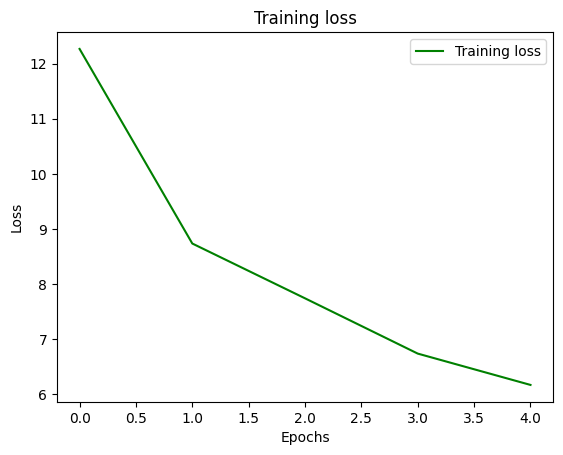

LOSSES:  [12.266762744289293, 8.736570094342829, 7.742538423667147, 6.739740179219367, 6.171588478989362]
ACCURACIES:  [0.1861, 0.2575, 0.2773, 0.3136, 0.334]
Accuracy: 11.06%
Mean loss: 14.641534734276242
Done epoch : 1
Accuracy: 18.19%
Mean loss: 11.231388469662148
Done epoch : 2
Accuracy: 18.47%
Mean loss: 9.73081568207577
Done epoch : 3
Accuracy: 24.91%
Mean loss: 7.924503299392713
Done epoch : 4
Accuracy: 26.57%
Mean loss: 6.791695501356285
Done epoch : 5


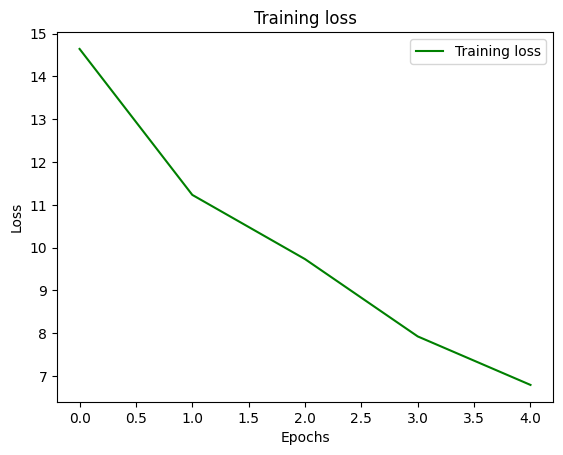

LOSSES:  [14.641534734276242, 11.231388469662148, 9.73081568207577, 7.924503299392713, 6.791695501356285]
ACCURACIES:  [0.1106, 0.1819, 0.1847, 0.2491, 0.2657]
Accuracy: 15.659999999999998%
Mean loss: 14.817726932874468
Done epoch : 1
Accuracy: 17.52%
Mean loss: 11.410555719923538
Done epoch : 2
Accuracy: 22.32%
Mean loss: 7.895428708409915
Done epoch : 3
Accuracy: 26.740000000000002%
Mean loss: 6.7184732526929185
Done epoch : 4
Accuracy: 30.270000000000003%
Mean loss: 5.958099258436534
Done epoch : 5


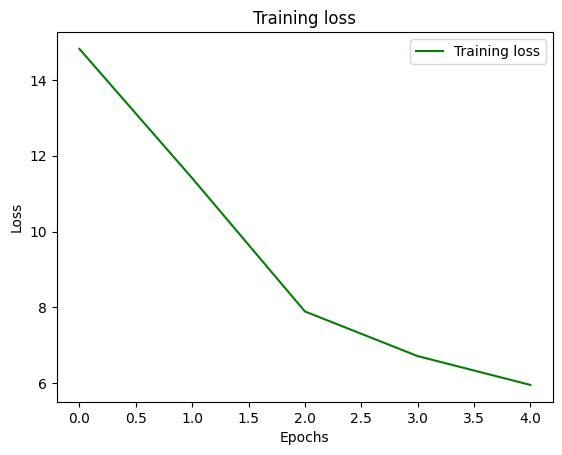

LOSSES:  [14.817726932874468, 11.410555719923538, 7.895428708409915, 6.7184732526929185, 5.958099258436534]
ACCURACIES:  [0.1566, 0.1752, 0.2232, 0.2674, 0.3027]


In [12]:
for i in range(1):
    model(5, 1e-5)

In [8]:
# r_t_test = m_t_test.reshape((m_t_test.shape[0], 1))
# m_x_test_normize = n_normalize(m_x_test, ma, mi)

# len_test =  len(m_x_test_normize)
# correct = 0

# for i in range(len_test):
#     t = one_hot(r_t_test[i][0], 10)
#     x = m_x_test_normize[i]

#     k = lin(x, W, b)
#     h = n_sigmoid(k)
#     o = lin(h, V, c)
#     y = n_softmax(o)
    
#     if y.argmax() == t.argmax():
#         correct += 1

# print(f'Accuracy: {(correct/len_test) * 100}%')

Accuracy: 27.01%


Compare the training loss per epoch to the validation loss per epoch. What does the difference tell you?

<!-- As shown by the graph each epochs loss decresses. Therefore this tells us that the cross entropy loss between our models prediction and the true label is decreasing. Our model is getting better. -->



Train the neural network from a random initialization multiple times (at least 3) and plot an average and a standard deviation of the objective value in each iteration. What does this tell you?

Run the SGD with different learning rates (e.g., 0.001, 0.003, 0.01, 0.03). Analyze how the learning rate value influences the final performance.

Results
lr = 3e-2 : 0.03
lr = 1e-2 : 0.01
lr = 1e-3 : 0.001
lr = 3e-3 : 0.003
lr = 1e-5 : 0.00001

Based on these experiments, choose a final set of hyperparameters. Then load the full training data with the canonical test set, train your model with the chosen hyperparameters and report the accuracy you get.

LEARNING RATE:  0.03
Accuracy: 14.91%
Mean loss: 17.987656858935846
Done epoch : 1
Accuracy: 20.119999999999997%
Mean loss: 13.3652515662037
Done epoch : 2
Accuracy: 20.580000000000002%
Mean loss: 11.151612125000423
Done epoch : 3
Accuracy: 27.68%
Mean loss: 9.31123482788186
Done epoch : 4
Accuracy: 26.33%
Mean loss: 7.9171548130323774
Done epoch : 5


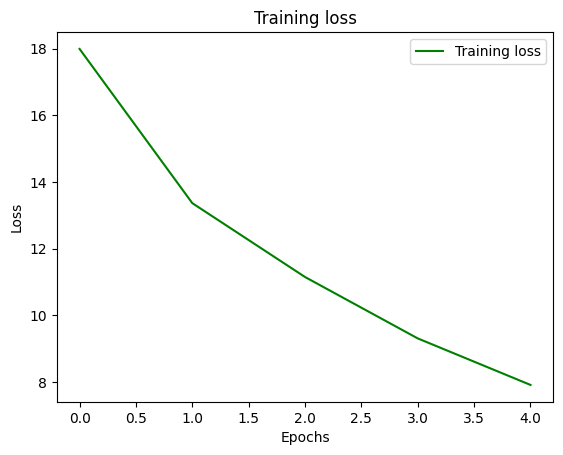

LOSSES:  [17.987656858935846, 13.3652515662037, 11.151612125000423, 9.31123482788186, 7.9171548130323774]
ACCURACIES:  [0.1491, 0.2012, 0.2058, 0.2768, 0.2633]
LEARNING RATE:  0.01
Accuracy: 11.07%
Mean loss: 19.21525221490199
Done epoch : 1
Accuracy: 12.36%
Mean loss: 14.34466612397474
Done epoch : 2
Accuracy: 14.81%
Mean loss: 10.61691915969877
Done epoch : 3
Accuracy: 21.51%
Mean loss: 8.318871147281914
Done epoch : 4
Accuracy: 24.58%
Mean loss: 7.0085250464307345
Done epoch : 5


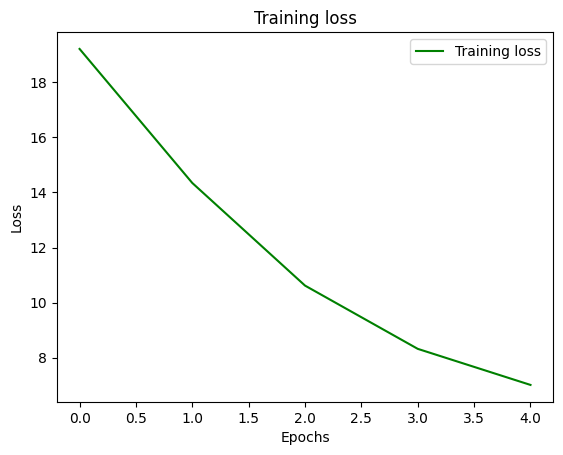

LOSSES:  [19.21525221490199, 14.34466612397474, 10.61691915969877, 8.318871147281914, 7.0085250464307345]
ACCURACIES:  [0.1107, 0.1236, 0.1481, 0.2151, 0.2458]
LEARNING RATE:  0.001
Accuracy: 8.780000000000001%
Mean loss: 18.209444421131835
Done epoch : 1
Accuracy: 17.39%
Mean loss: 12.448462139155362
Done epoch : 2
Accuracy: 15.97%
Mean loss: 9.761180038950585
Done epoch : 3
Accuracy: 23.48%
Mean loss: 8.046083565147347
Done epoch : 4
Accuracy: 24.310000000000002%
Mean loss: 7.081553704089874
Done epoch : 5


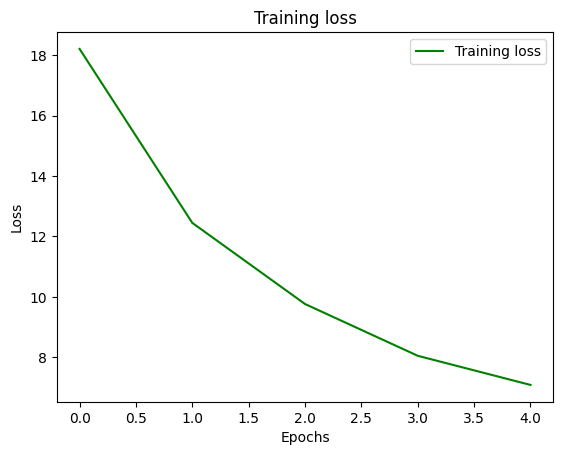

LOSSES:  [18.209444421131835, 12.448462139155362, 9.761180038950585, 8.046083565147347, 7.081553704089874]
ACCURACIES:  [0.0878, 0.1739, 0.1597, 0.2348, 0.2431]
LEARNING RATE:  0.003
Accuracy: 16.189999999999998%
Mean loss: 15.14608498706951
Done epoch : 1
Accuracy: 17.01%
Mean loss: 9.402842531810538
Done epoch : 2
Accuracy: 25.81%
Mean loss: 7.740933556990988
Done epoch : 3
Accuracy: 28.58%
Mean loss: 6.273288805631088
Done epoch : 4
Accuracy: 32.49%
Mean loss: 5.6266896944667275
Done epoch : 5


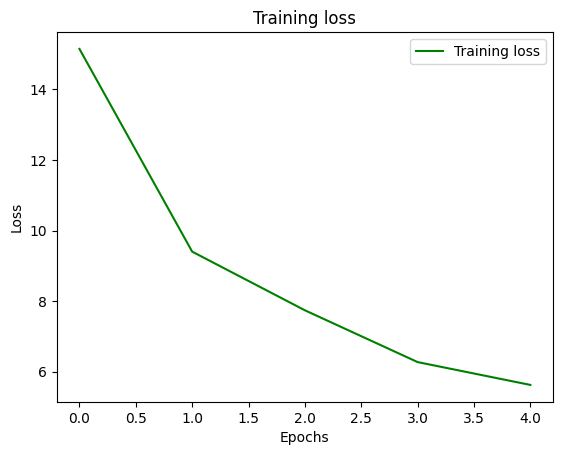

LOSSES:  [15.14608498706951, 9.402842531810538, 7.740933556990988, 6.273288805631088, 5.6266896944667275]
ACCURACIES:  [0.1619, 0.1701, 0.2581, 0.2858, 0.3249]
LEARNING RATE:  1e-05
Accuracy: 10.95%
Mean loss: 14.270845345083412
Done epoch : 1
Accuracy: 13.700000000000001%
Mean loss: 11.34177539468042
Done epoch : 2
Accuracy: 16.32%
Mean loss: 9.264645328050491
Done epoch : 3
Accuracy: 20.22%
Mean loss: 8.114097894224827
Done epoch : 4
Accuracy: 24.529999999999998%
Mean loss: 7.18031112486321
Done epoch : 5


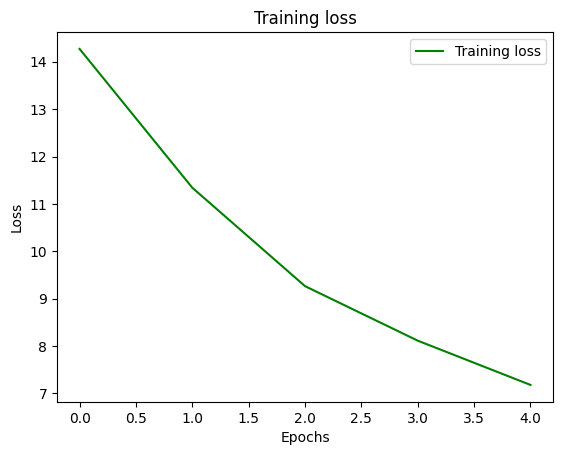

LOSSES:  [14.270845345083412, 11.34177539468042, 9.264645328050491, 8.114097894224827, 7.18031112486321]
ACCURACIES:  [0.1095, 0.137, 0.1632, 0.2022, 0.2453]


In [13]:
diff_lr = [3e-2, 1e-2, 1e-3, 3e-3, 1e-5]

for j in diff_lr:
    print('LEARNING RATE: ', j)
    model(5, j)

Accuracy: 11.866666666666667%
Mean loss: 19.08532732807155
Done epoch : 1
Accuracy: 19.166666666666668%
Mean loss: 13.383310864631753
Done epoch : 2
Accuracy: 20.1%
Mean loss: 10.703942170772988
Done epoch : 3
Accuracy: 25.291666666666668%
Mean loss: 9.00983605322592
Done epoch : 4
Accuracy: 25.59166666666667%
Mean loss: 7.30779312911928
Done epoch : 5


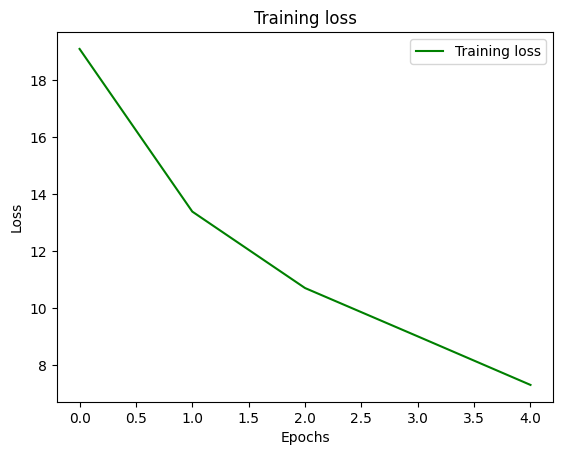

LOSSES:  [19.08532732807155, 13.383310864631753, 10.703942170772988, 9.00983605322592, 7.30779312911928]
ACCURACIES:  [0.11866666666666667, 0.19166666666666668, 0.201, 0.2529166666666667, 0.2559166666666667]
VALIDATION LOSSES:  [13.413359199168582, 10.682406556286868, 8.98551311369888, 7.277996432205128, 6.313141145652487]


In [58]:
for i in range(1):
    model(5, 1e-5)

In [59]:
len(m_x_train_normize)

60000

Accuracy: 14.466666666666667%
Mean loss: 14.310621191534082
Done epoch : 1
Accuracy: 17.05%
Mean loss: 10.656591450317928
Done epoch : 2
Accuracy: 21.4%
Mean loss: 8.156356771492835
Done epoch : 3
Accuracy: 24.25%
Mean loss: 7.060448333463531
Done epoch : 4
Accuracy: 28.9%
Mean loss: 6.295960172059902
Done epoch : 5


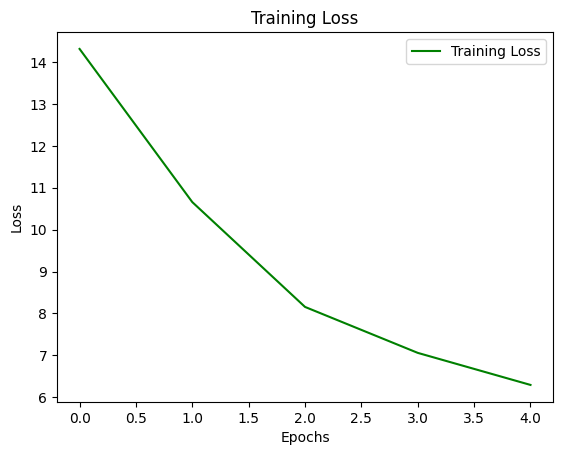

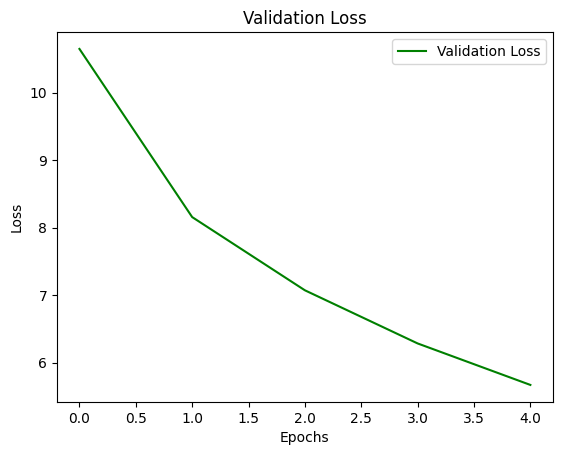

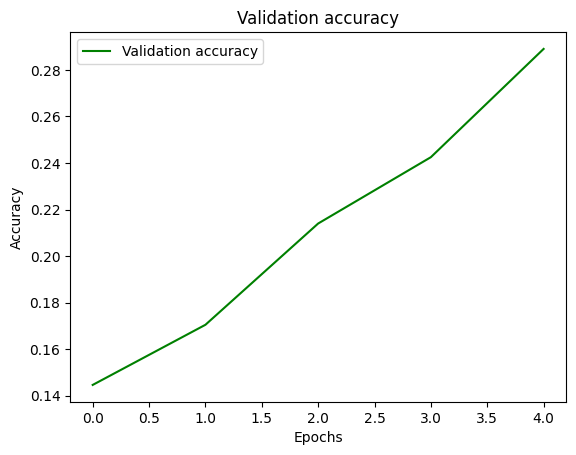

LOSSES:  [14.310621191534082, 10.656591450317928, 8.156356771492835, 7.060448333463531, 6.295960172059902]
ACCURACIES:  [0.14466666666666667, 0.1705, 0.214, 0.2425, 0.289]
VALIDATION LOSSES:  [10.648348106530733, 8.157020602460715, 7.0723891200623985, 6.28511194376832, 5.670590752530705]


In [64]:
for i in range(1):
    model(5, 1e-5)

Accuracy: 8.9%
Mean loss: 21.682023455090086
Done epoch : 1
Accuracy: 11.559999999999999%
Mean loss: 14.84608104279673
Done epoch : 2
Accuracy: 13.86%
Mean loss: 11.342820101356534
Done epoch : 3
Accuracy: 21.9%
Mean loss: 8.986581956286143
Done epoch : 4
Accuracy: 21.54%
Mean loss: 7.409882339719297
Done epoch : 5


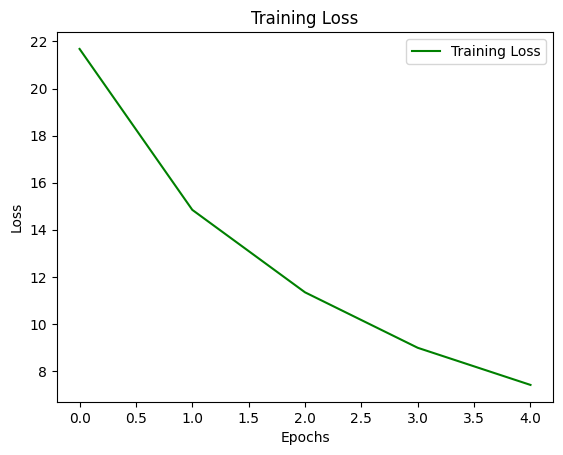

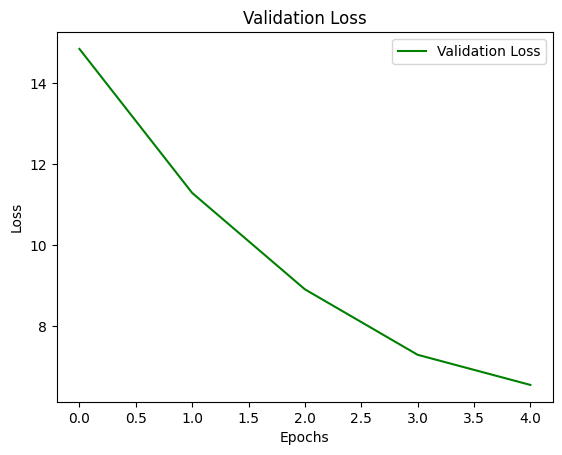

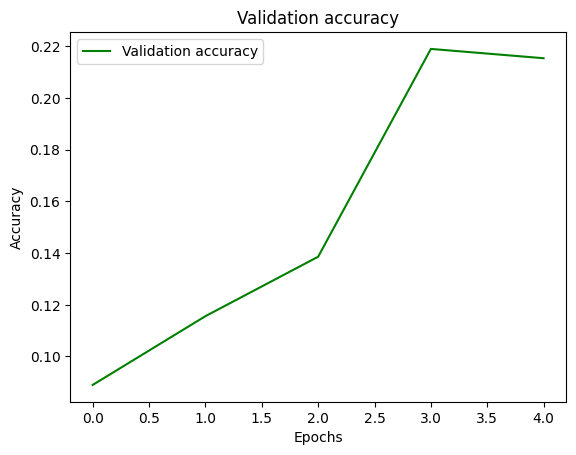

LOSSES:  [21.682023455090086, 14.84608104279673, 11.342820101356534, 8.986581956286143, 7.409882339719297]
ACCURACIES:  [0.089, 0.1156, 0.1386, 0.219, 0.2154]
VALIDATION LOSSES:  [14.853101740161243, 11.295640728183562, 8.914639197009912, 7.297202578297609, 6.552898400363789]


In [71]:
for i in range(1):
    model(5, 1e-5)

# Now lets actually begin the report!

In [138]:
# lets store all the weights we train
trained_W = []
trained_B = []
trained_V = []
trained_C = []

### 1. Compare the training loss per epoch to the validation loss per epoch. What does the difference tell you?

STARTING TRAINING
Accuracy: 8.84%
STD: 13.88099431279793
Mean loss: 19.0426783038999
Done epoch : 1
Accuracy: 10.56%
STD: 8.372912372208974
Mean loss: 12.698640308758016
Done epoch : 2
Accuracy: 13.719999999999999%
STD: 7.126524370918528
Mean loss: 10.376220924566601
Done epoch : 3
Accuracy: 17.24%
STD: 6.78901700817088
Mean loss: 9.026049703711305
Done epoch : 4
Accuracy: 21.0%
STD: 6.298482795134195
Mean loss: 7.945116838833259
Done epoch : 5
LOSSES:  [19.0426783038999, 12.698640308758016, 10.376220924566601, 9.026049703711305, 7.945116838833259]
ACCURACIES:  [0.0884, 0.1056, 0.1372, 0.1724, 0.21]
VALIDATION LOSSES:  [12.466074319891616, 10.02849127876845, 8.63326892697238, 7.551288179713995, 6.576602491615139]
STD [13.88099431279793, 8.372912372208974, 7.126524370918528, 6.78901700817088, 6.298482795134195]
VALIDATION STD [8.233643325237987, 6.912006912279383, 6.527119231053423, 6.08147013769432, 5.673848912209569]


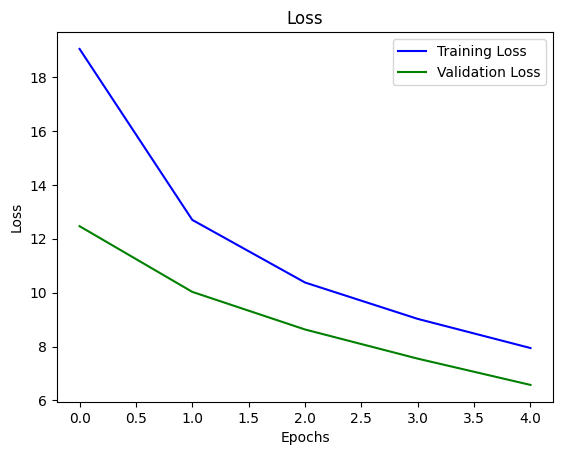

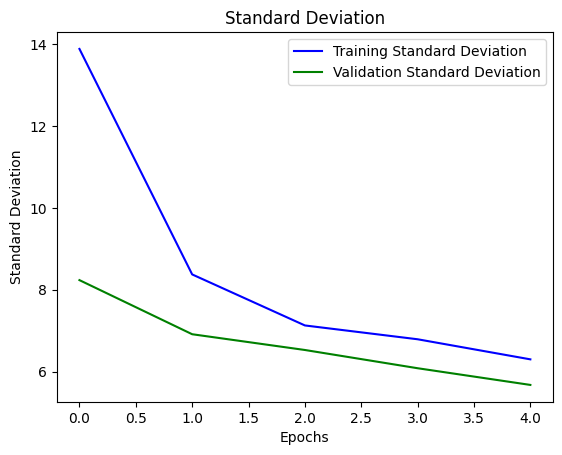

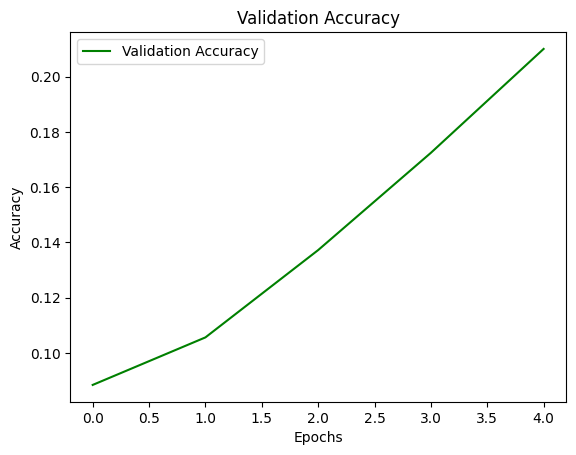

DONE TRAINING
NUM OF TRAINED WEIGHTS: 1


In [139]:
for i in range(1):
    
    print('STARTING TRAINING')
    W, b, V, c = model(5, 1e-5)
    print('DONE TRAINING')
    
    trained_W.append(W)
    trained_B.append(b)
    trained_V.append(V)
    trained_C.append(c)
    
print(f'NUM OF TRAINED WEIGHTS: {len(trained_W)}')

### 2. Train the neural network from a random initialization multiple times (at least 3) and plot an average and a standard deviation of the objective value in each iteration. What does this tell you?

STARTING TRAINING
Accuracy: 9.32%
STD: 11.88992494672882
Mean loss: 18.819880251146188
Done epoch : 1
Accuracy: 12.76%
STD: 10.035478975255053
Mean loss: 14.221262843838137
Done epoch : 2
Accuracy: 17.72%
STD: 7.809927161262147
Mean loss: 10.320649801408672
Done epoch : 3
Accuracy: 21.36%
STD: 6.638681101544331
Mean loss: 8.1083139038557
Done epoch : 4
Accuracy: 24.68%
STD: 6.281948212646866
Mean loss: 7.2179942988919406
Done epoch : 5
LOSSES:  [18.819880251146188, 14.221262843838137, 10.320649801408672, 8.1083139038557, 7.2179942988919406]
ACCURACIES:  [0.0932, 0.1276, 0.1772, 0.2136, 0.2468]
VALIDATION LOSSES:  [14.298138967061197, 10.429593202092846, 8.16159787732718, 7.227051960675617, 6.480715033808861]
STD [11.88992494672882, 10.035478975255053, 7.809927161262147, 6.638681101544331, 6.281948212646866]
VALIDATION STD [10.323906161776494, 7.994744483411731, 6.695395567425721, 6.331258244175697, 6.026023554912267]


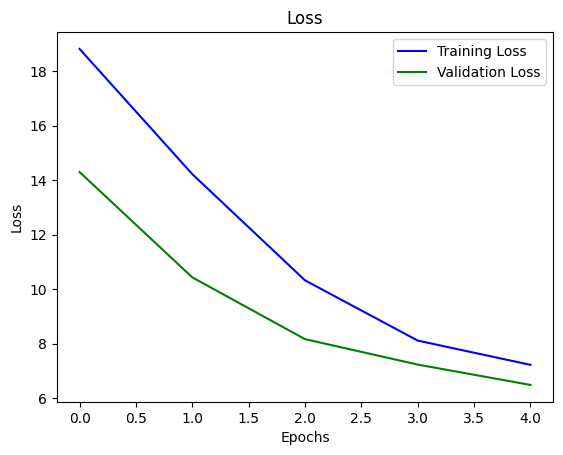

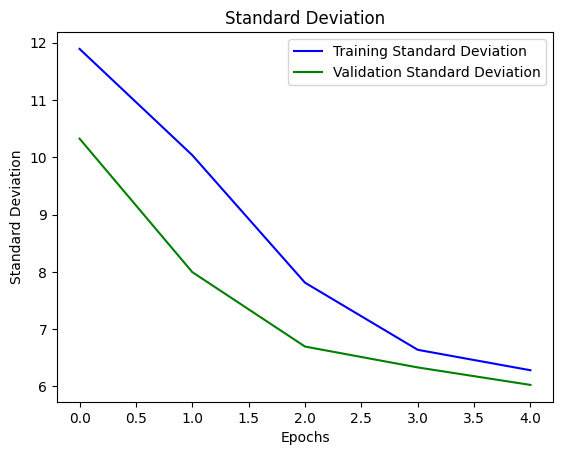

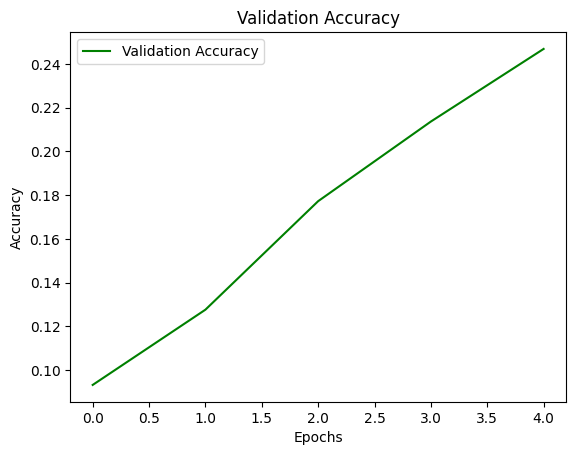

DONE TRAINING
STARTING TRAINING
Accuracy: 12.540000000000001%
STD: 12.52007725481146
Mean loss: 17.53066925000669
Done epoch : 1
Accuracy: 16.38%
STD: 10.58717174446782
Mean loss: 13.041656459403631
Done epoch : 2
Accuracy: 17.1%
STD: 7.476003501310194
Mean loss: 9.400337961387288
Done epoch : 3
Accuracy: 26.16%
STD: 5.771770606442942
Mean loss: 7.067187024878699
Done epoch : 4
Accuracy: 24.82%
STD: 5.866188439621713
Mean loss: 6.374257827735703
Done epoch : 5
LOSSES:  [17.53066925000669, 13.041656459403631, 9.400337961387288, 7.067187024878699, 6.374257827735703]
ACCURACIES:  [0.1254, 0.1638, 0.171, 0.2616, 0.2482]
VALIDATION LOSSES:  [12.872418061441396, 9.348475606246394, 6.876479613241124, 6.275240550651281, 5.3721470965964135]
STD [12.52007725481146, 10.58717174446782, 7.476003501310194, 5.771770606442942, 5.866188439621713]
VALIDATION STD [10.647493260128158, 7.5198930999450795, 5.676941046224338, 5.759645346836198, 5.085163299593667]


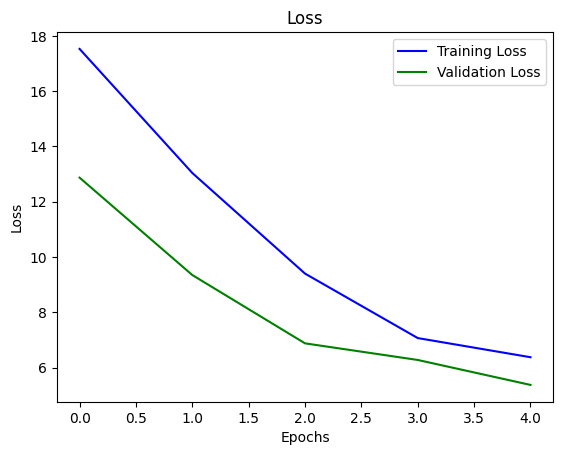

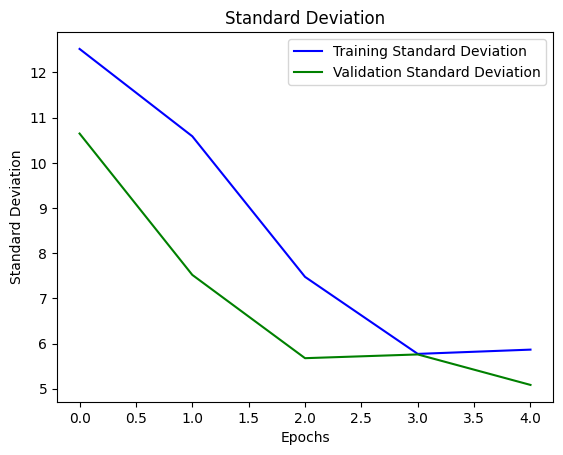

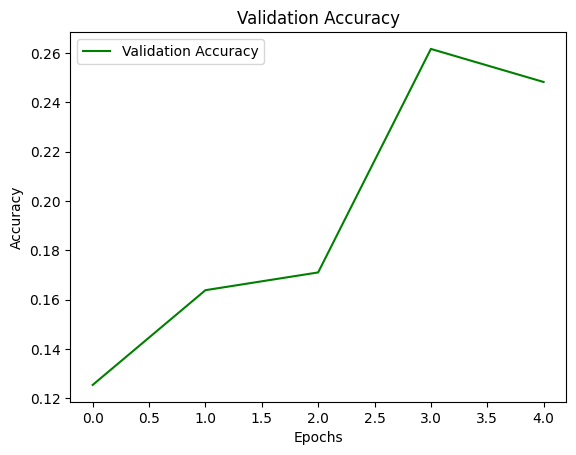

DONE TRAINING
STARTING TRAINING
Accuracy: 12.4%
STD: 11.36241385604729
Mean loss: 15.933736391188352
Done epoch : 1
Accuracy: 16.24%
STD: 9.04725921571957
Mean loss: 11.560030815929268
Done epoch : 2
Accuracy: 18.060000000000002%
STD: 7.4318158860021075
Mean loss: 9.445980854759052
Done epoch : 3
Accuracy: 23.18%
STD: 6.416528822165025
Mean loss: 7.577655791680208
Done epoch : 4
Accuracy: 24.64%
STD: 6.278350466648368
Mean loss: 6.806958211755672
Done epoch : 5
LOSSES:  [15.933736391188352, 11.560030815929268, 9.445980854759052, 7.577655791680208, 6.806958211755672]
ACCURACIES:  [0.124, 0.1624, 0.1806, 0.2318, 0.2464]
VALIDATION LOSSES:  [11.515375186284333, 9.535082090618781, 7.611922965622271, 6.861131057355605, 6.103114644034032]
STD [11.36241385604729, 9.04725921571957, 7.4318158860021075, 6.416528822165025, 6.278350466648368]
VALIDATION STD [8.809721042758836, 7.370719716796829, 6.225396128495408, 6.188374680718477, 5.7008081617938755]


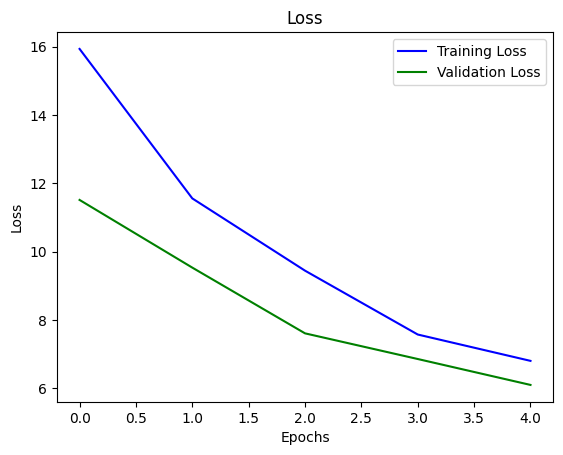

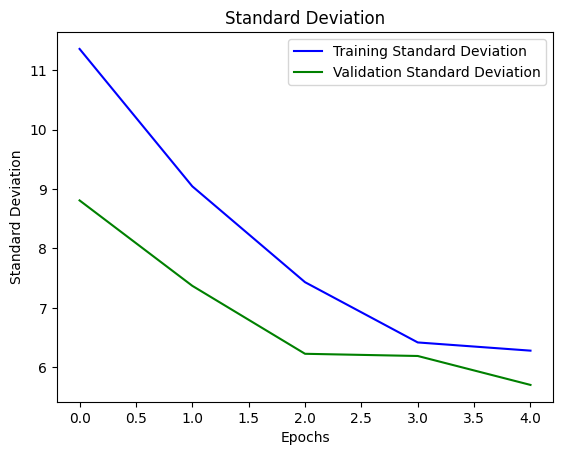

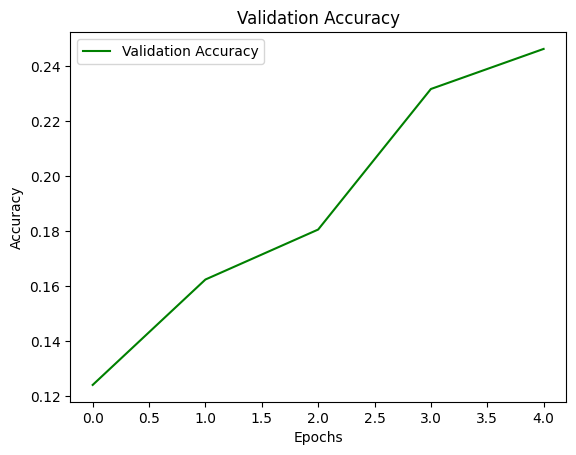

DONE TRAINING
NUM OF TRAINED WEIGHTS: 4


In [140]:
for i in range(3):
    
    print('STARTING TRAINING')
    W, b, V, c = model(5, 1e-5)
    print('DONE TRAINING')
    
    trained_W.append(W)
    trained_B.append(b)
    trained_V.append(V)
    trained_C.append(c)
    
print(f'NUM OF TRAINED WEIGHTS: {len(trained_W)}')

### 3. Run the SGD with different learning rates (e.g., 0.001, 0.003, 0.01, 0.03). Analyze how the learning rate value influences the final performance.

STARTING TRAINING
LEARNING RATE:  0.03
Accuracy: 12.920000000000002%
STD: 14.80977739421208
Mean loss: 26.059557840740716
Done epoch : 1
Accuracy: 16.24%
STD: 14.170745694737
Mean loss: 17.982580781141618
Done epoch : 2
Accuracy: 17.34%
STD: 10.738589875138894
Mean loss: 12.50414431878453
Done epoch : 3
Accuracy: 22.16%
STD: 8.406875228480837
Mean loss: 9.730135113974145
Done epoch : 4
Accuracy: 23.78%
STD: 7.193114410541189
Mean loss: 7.89107022799146
Done epoch : 5
LOSSES:  [26.059557840740716, 17.982580781141618, 12.50414431878453, 9.730135113974145, 7.89107022799146]
ACCURACIES:  [0.1292, 0.1624, 0.1734, 0.2216, 0.2378]
VALIDATION LOSSES:  [18.31737279986621, 12.805745410814097, 9.94977144252154, 8.083274632740697, 6.901713394035326]
STD [14.80977739421208, 14.170745694737, 10.738589875138894, 8.406875228480837, 7.193114410541189]
VALIDATION STD [14.529847381840504, 11.25582724262062, 8.839928244351551, 7.414174234469747, 6.312828185952735]


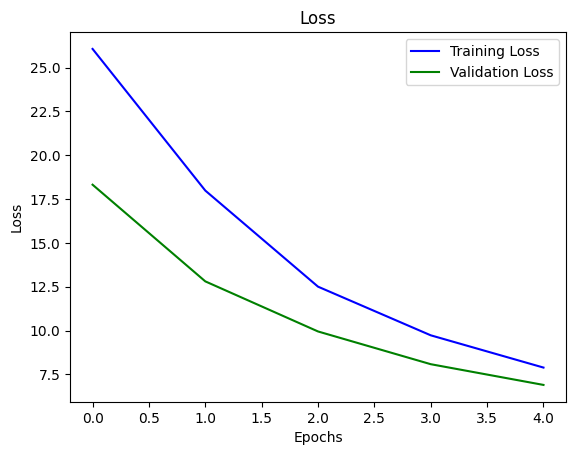

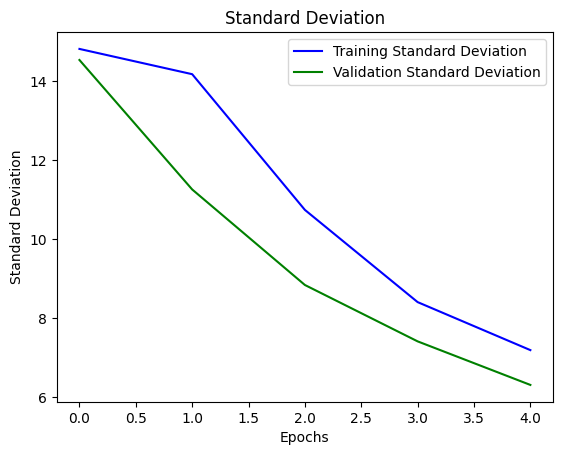

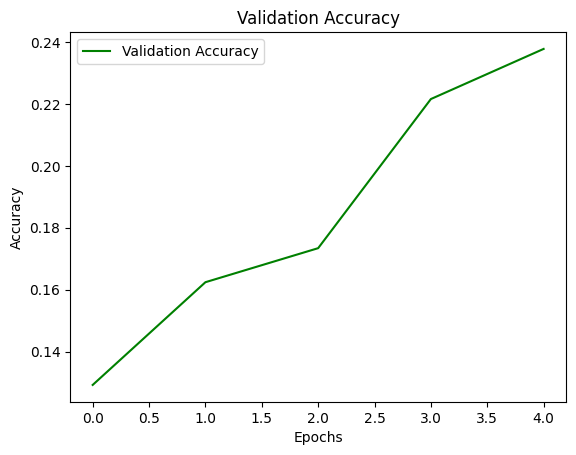

DONE TRAINING
STARTING TRAINING
LEARNING RATE:  0.01
Accuracy: 12.2%
STD: 10.552028366910823
Mean loss: 15.105052796354958
Done epoch : 1
Accuracy: 18.52%
STD: 8.322585105368397
Mean loss: 11.056611261186724
Done epoch : 2
Accuracy: 20.380000000000003%
STD: 6.988657954145956
Mean loss: 8.45498333419582
Done epoch : 3
Accuracy: 25.240000000000002%
STD: 6.234802949386498
Mean loss: 7.306154120410703
Done epoch : 4
Accuracy: 27.02%
STD: 5.9438632949864205
Mean loss: 6.468621562401394
Done epoch : 5
LOSSES:  [15.105052796354958, 11.056611261186724, 8.45498333419582, 7.306154120410703, 6.468621562401394]
ACCURACIES:  [0.122, 0.1852, 0.2038, 0.2524, 0.2702]
VALIDATION LOSSES:  [11.014561999362085, 8.47514130544317, 7.216916957464439, 6.39127454452654, 5.785703151176428]
STD [10.552028366910823, 8.322585105368397, 6.988657954145956, 6.234802949386498, 5.9438632949864205]
VALIDATION STD [8.295177032917762, 6.8752841695047024, 6.16089200496953, 5.829537287498135, 5.5400979088485]


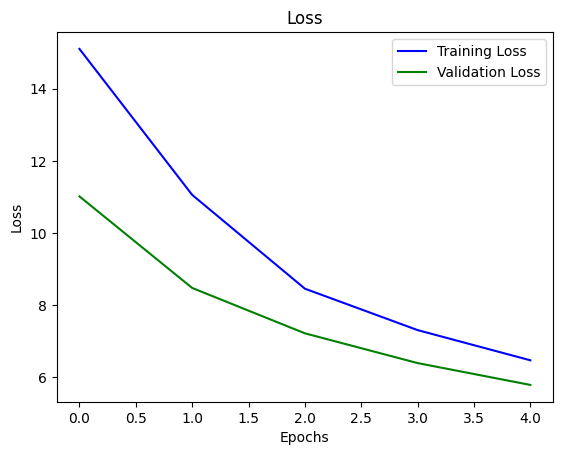

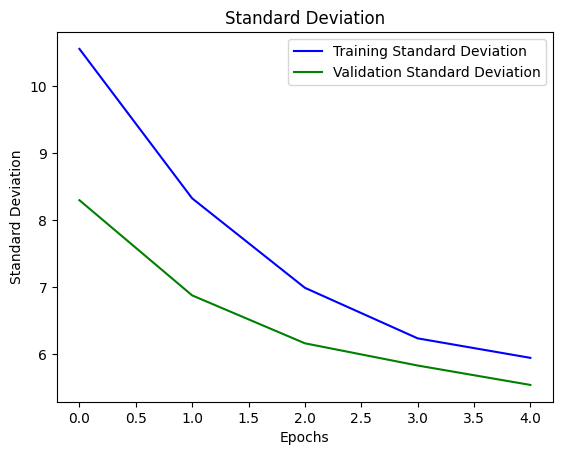

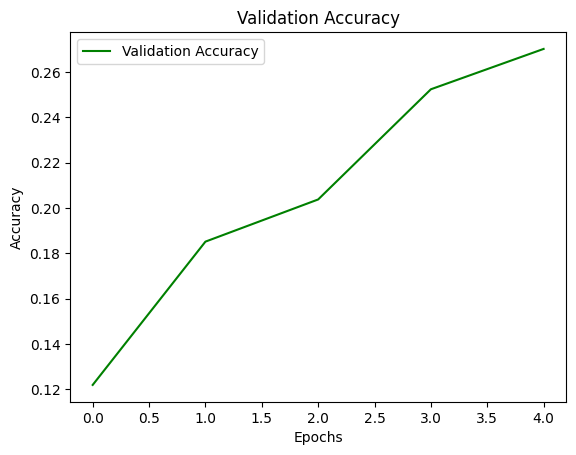

DONE TRAINING
STARTING TRAINING
LEARNING RATE:  0.001
Accuracy: 13.18%
STD: 13.314758747901845
Mean loss: 25.730845102990344
Done epoch : 1
Accuracy: 21.12%
STD: 12.78489076969692
Mean loss: 14.5695691155782
Done epoch : 2
Accuracy: 23.24%
STD: 10.229635225729684
Mean loss: 11.050091717333977
Done epoch : 3
Accuracy: 29.56%
STD: 7.8797018292186385
Mean loss: 8.194185701703946
Done epoch : 4
Accuracy: 33.78%
STD: 6.501459934624824
Mean loss: 6.392711514267273
Done epoch : 5
LOSSES:  [25.730845102990344, 14.5695691155782, 11.050091717333977, 8.194185701703946, 6.392711514267273]
ACCURACIES:  [0.1318, 0.2112, 0.2324, 0.2956, 0.3378]
VALIDATION LOSSES:  [14.484144643567985, 10.779132396221868, 7.971426774932956, 6.160486934899661, 5.149173816679697]
STD [13.314758747901845, 12.78489076969692, 10.229635225729684, 7.8797018292186385, 6.501459934624824]
VALIDATION STD [12.71991517411722, 9.95568853270205, 7.674114273853879, 6.3427481808977095, 5.6326340850932555]


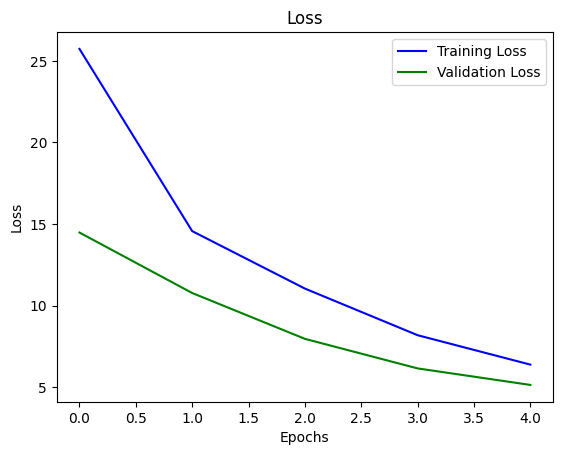

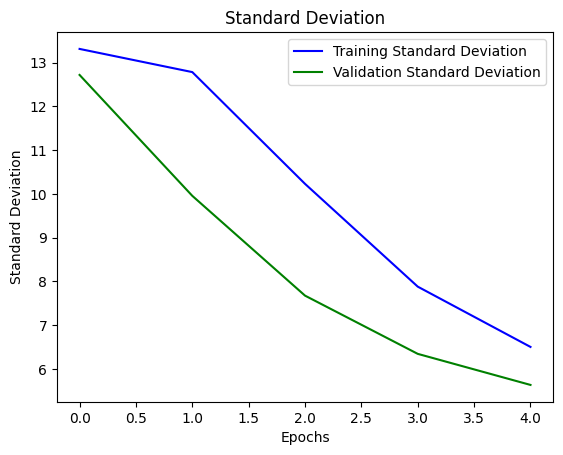

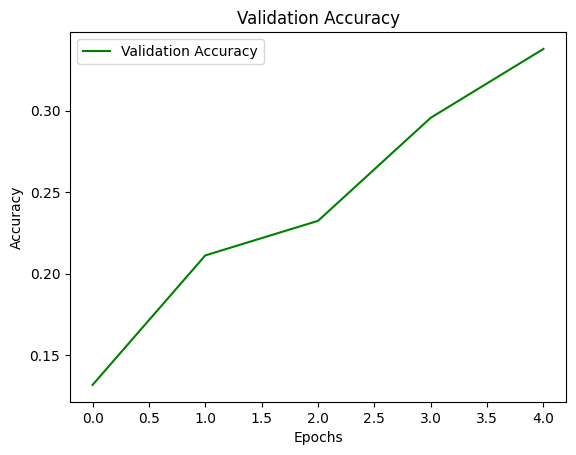

DONE TRAINING
STARTING TRAINING
LEARNING RATE:  0.003
Accuracy: 11.18%
STD: 13.53347667517341
Mean loss: 24.777127292905277
Done epoch : 1
Accuracy: 16.1%
STD: 11.921743839298266
Mean loss: 14.639985943281491
Done epoch : 2
Accuracy: 20.22%
STD: 10.439126414930094
Mean loss: 11.737255566619128
Done epoch : 3
Accuracy: 22.78%
STD: 8.299436584878178
Mean loss: 9.345494530620469
Done epoch : 4
Accuracy: 28.88%
STD: 6.740522481725348
Mean loss: 7.333672356283956
Done epoch : 5
LOSSES:  [24.777127292905277, 14.639985943281491, 11.737255566619128, 9.345494530620469, 7.333672356283956]
ACCURACIES:  [0.1118, 0.161, 0.2022, 0.2278, 0.2888]
VALIDATION LOSSES:  [14.512715349390085, 11.418869866914065, 8.949383283711137, 6.967334377618611, 6.042130028955324]
STD [13.53347667517341, 11.921743839298266, 10.439126414930094, 8.299436584878178, 6.740522481725348]
VALIDATION STD [11.80738410629104, 10.352638035149038, 8.124403533643806, 6.581153501426161, 6.101962903028302]


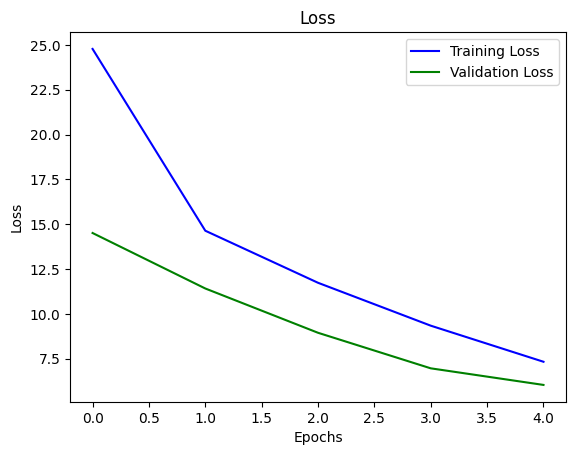

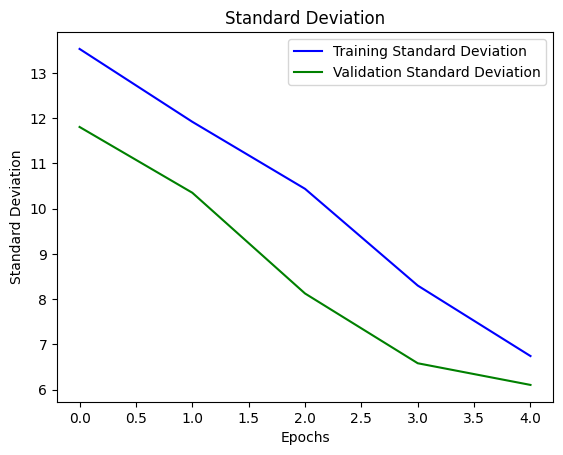

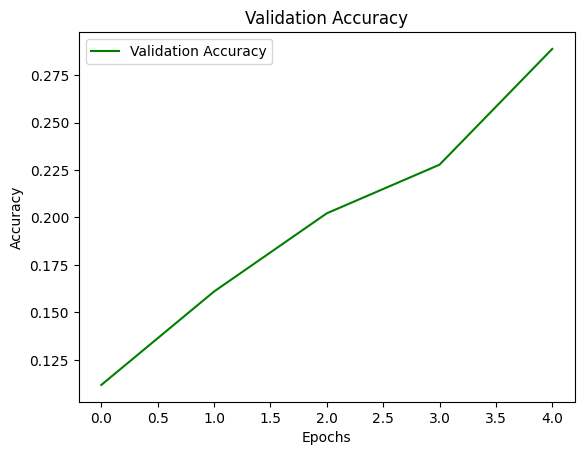

DONE TRAINING
STARTING TRAINING
LEARNING RATE:  1e-05
Accuracy: 11.68%
STD: 11.084366706517914
Mean loss: 18.25444589819692
Done epoch : 1
Accuracy: 16.78%
STD: 10.601999786187475
Mean loss: 12.765154182910187
Done epoch : 2
Accuracy: 18.42%
STD: 8.624116562349466
Mean loss: 10.159118625732216
Done epoch : 3
Accuracy: 21.740000000000002%
STD: 6.946299172302911
Mean loss: 8.324882106473552
Done epoch : 4
Accuracy: 25.52%
STD: 6.0912436898907565
Mean loss: 6.963069001256311
Done epoch : 5
LOSSES:  [18.25444589819692, 12.765154182910187, 10.159118625732216, 8.324882106473552, 6.963069001256311]
ACCURACIES:  [0.1168, 0.1678, 0.1842, 0.2174, 0.2552]
VALIDATION LOSSES:  [13.018715738048169, 10.191775560212289, 8.352568512119245, 6.798034719921383, 6.074475235243421]
STD [11.084366706517914, 10.601999786187475, 8.624116562349466, 6.946299172302911, 6.0912436898907565]
VALIDATION STD [10.662203693376025, 8.777007637309573, 6.881796468677438, 5.937785909398665, 5.723381041018047]


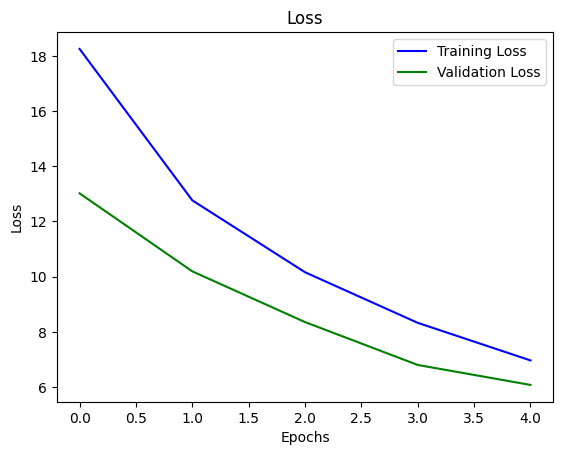

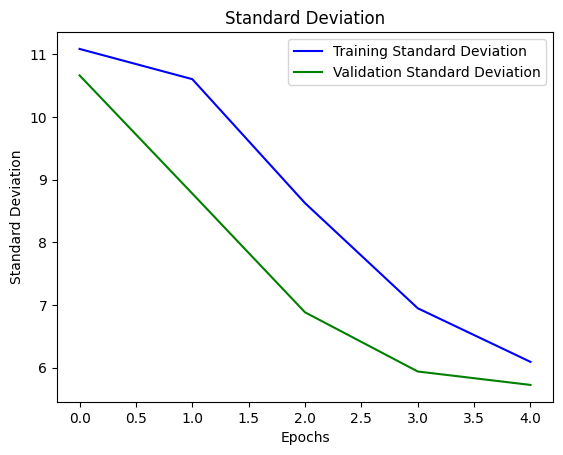

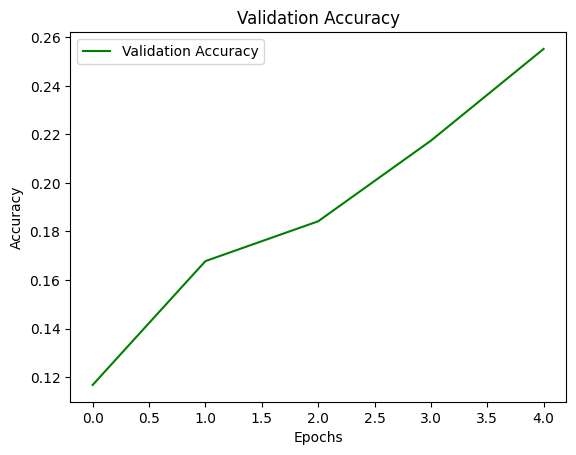

DONE TRAINING
NUM OF TRAINED WEIGHTS: 9


In [141]:
# Results
# lr = 3e-2 : 0.03
# lr = 1e-2 : 0.01
# lr = 1e-3 : 0.001
# lr = 3e-3 : 0.003
# lr = 1e-5 : 0.00001

diff_lr = [3e-2, 1e-2, 1e-3, 3e-3, 1e-5]

for j in diff_lr:
    
    print('STARTING TRAINING')
    print('LEARNING RATE: ', j)
    W, b, V, c = model(5, j)
    print('DONE TRAINING')
    
    trained_W.append(W)
    trained_B.append(b)
    trained_V.append(V)
    trained_C.append(c)
    
print(f'NUM OF TRAINED WEIGHTS: {len(trained_W)}')

### 4. Based on these experiments, choose a final set of hyperparameters. Then load the full training data with the canonical test set, train your model with the chosen hyperparameters and report the accuracy you get.

STARTING TRAINING
Accuracy: 11.379999999999999%
STD: 11.105477157357164
Mean loss: 16.805109065266976
Done epoch : 1
Accuracy: 15.440000000000001%
STD: 7.597788611931514
Mean loss: 10.902741471120187
Done epoch : 2
Accuracy: 16.7%
STD: 7.382072158938023
Mean loss: 9.427653697702144
Done epoch : 3
Accuracy: 24.84%
STD: 6.239089579365988
Mean loss: 7.8472325453292555
Done epoch : 4
Accuracy: 23.580000000000002%
STD: 6.336933084183334
Mean loss: 6.8818008807669635
Done epoch : 5
LOSSES:  [16.805109065266976, 10.902741471120187, 9.427653697702144, 7.8472325453292555, 6.8818008807669635]
ACCURACIES:  [0.1138, 0.1544, 0.167, 0.2484, 0.2358]
VALIDATION LOSSES:  [10.99596515457868, 9.617343261455524, 7.896106716518665, 6.864334167748903, 6.110226278438677]
STD [11.105477157357164, 7.597788611931514, 7.382072158938023, 6.239089579365988, 6.336933084183334]
VALIDATION STD [7.66871038389846, 7.401817550063323, 6.252995790545927, 6.371988730760926, 5.64056757441717]


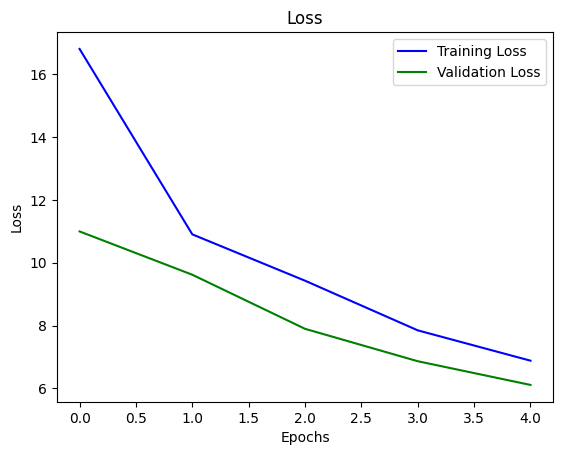

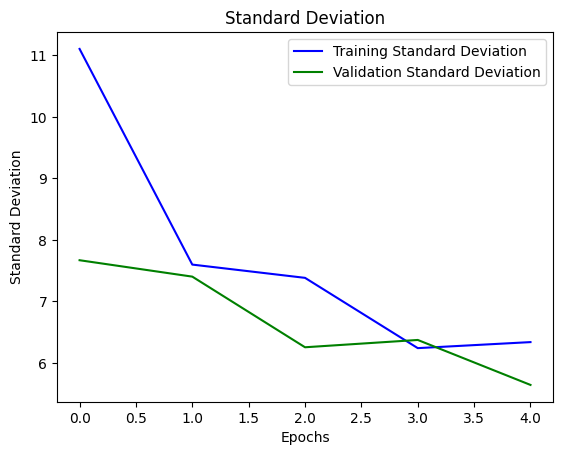

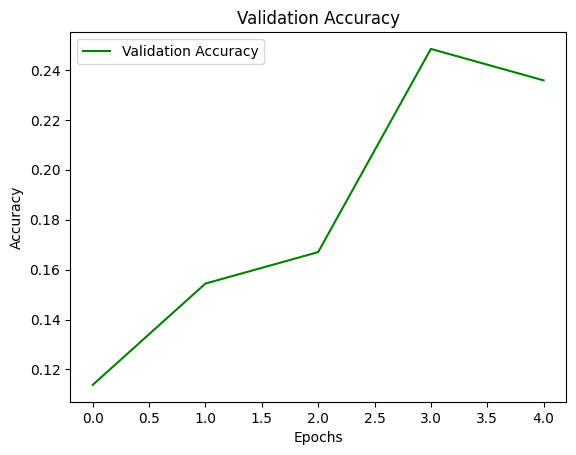

DONE TRAINING
Accuracy: 24.91%
STD: 5.654223082575546
Mean loss: 6.028761919989149
NUM OF TRAINED WEIGHTS: 11


In [147]:

for i in range(1):
    
    print('STARTING TRAINING')
    W, b, V, c = model(5, 1e-5)
    print('DONE TRAINING')
    
    trained_W.append(W)
    trained_B.append(b)
    trained_V.append(V)
    trained_C.append(c)
    
    # test on validation set
    len_test =  len(m_x_test_normize)
    correct = 0
    
    test_loss = []
    for i in range(len_test):
        x = m_x_test_normize[i]
        t = m_t_test_one_hot[i]

        k = lin(x, W, b)
        h = n_sigmoid(k)
        o = lin(h, V, c)
        y = n_softmax(o)
        
        l = n_cross_entropy(y, t)
        test_loss.append(l)
        
        if y.argmax() == t.argmax():
            correct += 1
            
    test_mean_loss = np.mean(test_loss)
    test_std = np.std(test_loss)
    
    acc = correct/len_test
    
    print(f'Accuracy: {(acc) * 100}%')
    print(f'STD: {(test_std)}')
    print(f'Mean loss: {(test_mean_loss)}')
    
print(f'NUM OF TRAINED WEIGHTS: {len(trained_W)}')